In [1]:
""" Barebones simulation of a Four Bar mechanism in drake """

import numpy as np
from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, Parser, Simulator, 
                        MeshcatVisualizer, StartMeshcat)    

from pydrake.systems.primitives import ConstantVectorSource

from pydrake.multibody import math as m
from pydrake.multibody.tree import LinearBushingRollPitchYaw

from pydrake.systems.framework import LeafSystem

# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
body = Parser(plant).AddModelFromFile("Four_Bar/four_bar_pendulum.urdf")

# Connect left and right hip via a bushing joint to form quasi closed loop robot
# Fixed joint using penalty method 3 for stiffness and method 2 for damping

# Get both bodies to connect
top = plant.GetBodyByName("top_dummy")
right = plant.GetBodyByName("right_dummy")

q_max = 0.1 * np.pi / 180  # 0.1 degrees maximum deviation
x_max = 1E-4  # 0.1 mm max deviation

M_max = 100   # Maximum estimated moment on the joint
F_max = 100   # Maximum estimated force on the joint

settling_time = 0.2 # Settling time in seconds
settling_ratio = 0.01   # Settling ratios must be either 0.01, 0.02, 0.05 or 0.10

def natural_freq(settling_ratio):
    return {"0.01": 6.64/settling_time,
            "0.02": 5.83/settling_time,
            "0.05": 4.74/settling_time,
            "0.10": 3.89/settling_time}[str(settling_ratio)]

w_n = natural_freq(settling_ratio)
zeta = 1. 

# Determine torque stiffness
k_theta = M_max / q_max * np.ones(3)

# Determine force stiffness
k_x = F_max / x_max * np.ones(3)

# Determine torque damping
d_theta = 2*zeta*k_theta / w_n

# Determine force damping
d_x = 2*zeta*k_x / w_n

# Create bushing element
bushing = plant.AddForceElement(LinearBushingRollPitchYaw(
            frameA=top.body_frame(),
            frameC=right.body_frame(),
            torque_stiffness_constants=k_theta,
            torque_damping_constants=d_theta,
            force_stiffness_constants=k_x,
            force_damping_constants=d_x))

# Finalize plant necessary for simulation
plant.Finalize()

# Visualization for the simulation
meshcat.Delete()
vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Create default context and fix the input to zeros to make diagram
context = plant.CreateDefaultContext()
x0 = np.zeros(plant.num_continuous_states())
plant.SetPositionsAndVelocities(context, x0)
# CoM_0 = plant.CalcCenterOfMassPositionInWorld(context)[0:2]

plant.get_actuation_input_port().FixValue(context, np.zeros(plant.num_actuators()))
nr_states = plant.num_continuous_states()


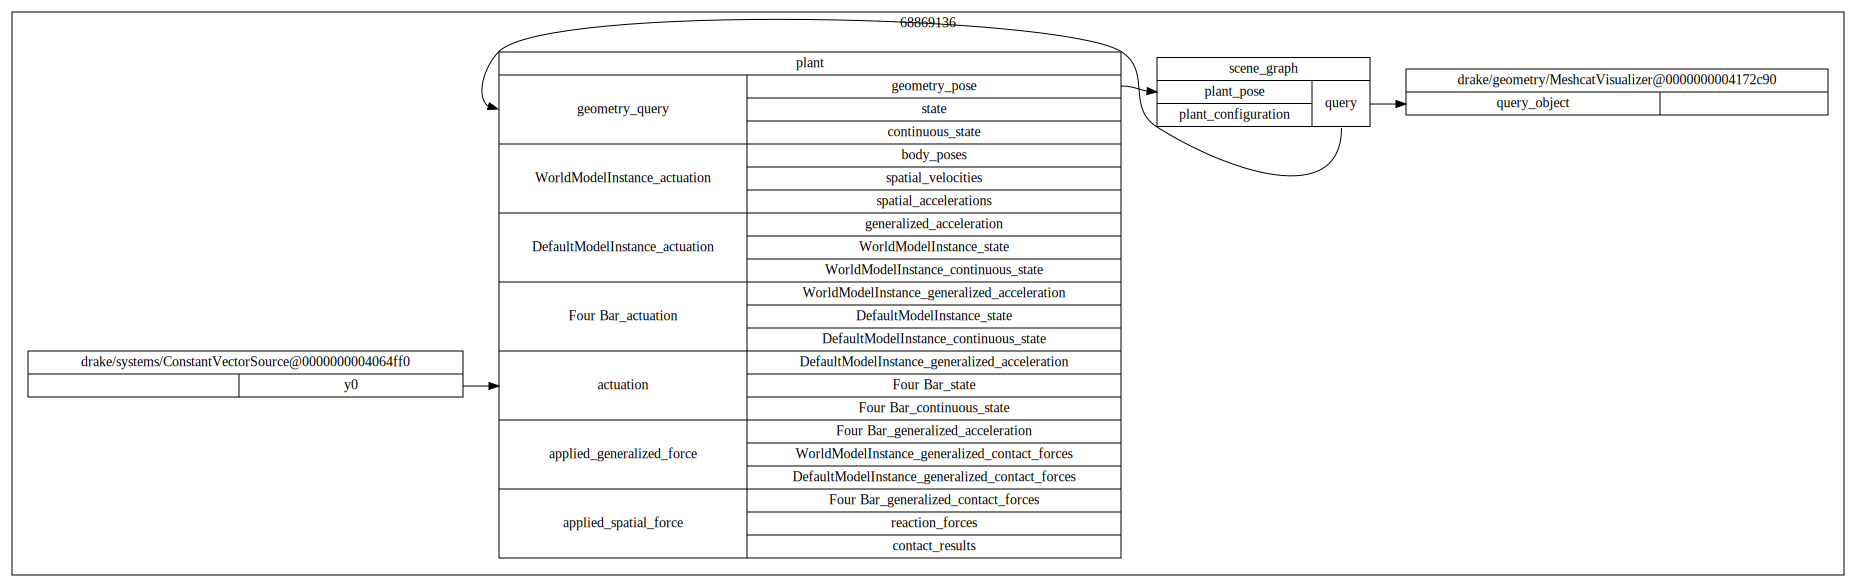

In [3]:
input = builder.AddSystem(ConstantVectorSource(np.zeros(plant.num_actuators())))
builder.Connect(input.get_output_port(), plant.get_actuation_input_port())

diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

In [4]:
# Simulator

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

sim_context.SetTime(0.)

q0 = np.array([0.01, 0, 0, 0])
x0 = np.hstack((q0, np.zeros(plant.num_velocities())))

sim_context.SetContinuousState(x0)

# Record the simulation of 2 seconds
vis.StartRecording()
simulator.set_publish_every_time_step(True)
simulator.AdvanceTo(2)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()